<h3><center>ECE 49500/59500 Machine Learning<center>
<center>Spring 2020<center>
<h2><center>Image Synthesis Using Generative Adversarial Networks<center>

<h4>Importing libraries

In [0]:
import matplotlib.pyplot as plt
import numpy as np

import keras
from keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Input, Reshape, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, UpSampling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam

Using TensorFlow backend.


<h4>Loading data

In [0]:
(data, _), (_, _) = keras.datasets.mnist.load_data()

print(data.shape)

11493376/11490434 [==============================] - 2s 0us/step
(60000, 28, 28)


<h4>Sampling real images

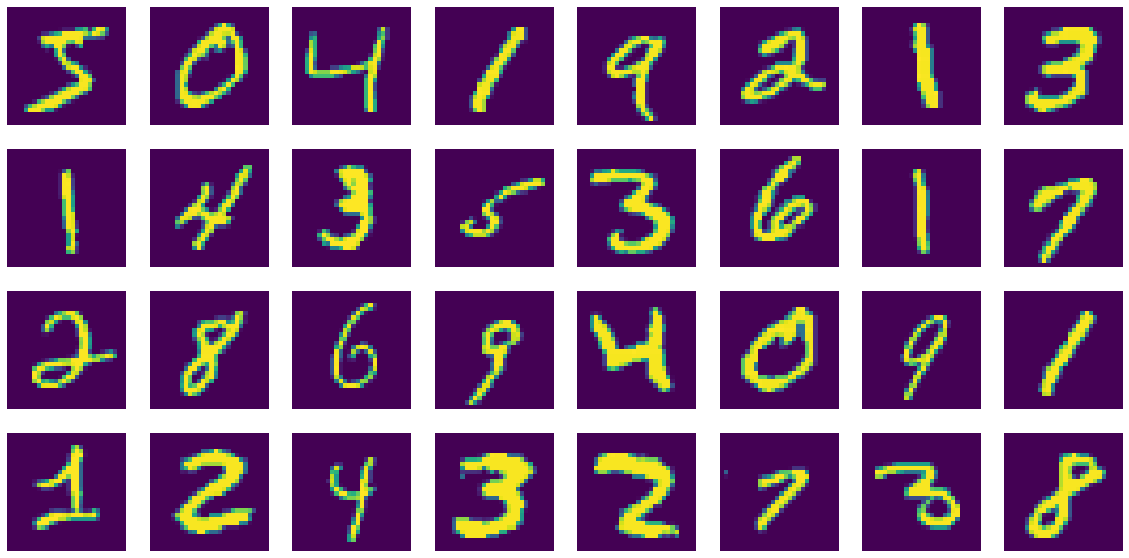

In [0]:
sample = data[:32]
_, ax = plt.subplots(4, 8, figsize=(20, 10))
for i, image in enumerate(sample):
    ax[i // 8, i % 8].imshow(image)
    ax[i // 8, i % 8].axis('off')
plt.show()

<h4>Reshaping and scaling the data

In [0]:
data = (np.reshape(data, (60000, 28, 28, 1)) / 127.5) - 1

In [0]:
image_shape = data.shape[1:]

print(image_shape)

(28, 28, 1)


<h4>Defining the size the of latent noise space

In [0]:
latent_dimensions = 100

<h4>Discriminator network

In [0]:
def build_discriminator():
    model = Sequential()

    model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=image_shape, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(512, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    image = Input(shape=image_shape)
    validity = model(image)

    return Model(image, validity)

<h4>Generator network

In [0]:
def build_generator():
    model = Sequential()
    # start with a 4x4 feature map
    model.add(Dense(4 * 4 * 256, activation="relu", input_dim=latent_dimensions))
    model.add(Reshape((4, 4, 256)))

    model.add(UpSampling2D())
    model.add(Conv2D(256, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size=3, padding="valid"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(UpSampling2D())
    model.add(Conv2D(64, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(Conv2D(1, kernel_size=3, padding="same"))
    model.add(Activation("tanh"))
    model.summary()

    noise = Input(shape=(latent_dimensions,))
    image = model(noise)

    return Model(noise, image)

<h4>Compiling the network

In [0]:
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

discriminator.trainable = False

generator = build_generator()

z = Input(shape=(latent_dimensions,))
image = generator(z)

valid = discriminator(image)

combined_network = Model(z, valid)
combined_network.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 64)        640       
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 128)        

<h4>Function to display generated images

In [0]:
def display_images():
    row, col = 5, 5
    noise = np.random.normal(0, 1, (row * col, latent_dimensions))
    generated_images = generator.predict(noise)
    generated_images = 0.5 * generated_images + 0.5
    generated_images = np.reshape(generated_images, (row * col, 28, 28))

    _, ax = plt.subplots(row, col, figsize=(12, 12))
    for i, image in enumerate(generated_images):
        ax[i // col, i % col].imshow(image)
        ax[i // col, i % col].axis('off')
    plt.show()
    plt.close()

<h4>Define hyperparameters and display interval

In [0]:
num_epochs = 15
batch_size = 64
display_interval = 1

<h4>Function to split data into batches

In [0]:
def make_batch(data, batch_size):
    batches = data.shape[0] // batch_size
    if data.shape[0] % batch_size != 0:
        buffer = batch_size - (data.shape[0] - batch_size * batches)
        idx = np.random.randint(0, data.shape[0], buffer)
        images = data[idx]
        new_data = np.row_stack((data, images))
        batches += 1
    batched_data = np.array(np.split(new_data, batches, axis=0))
    return batched_data

In [0]:
batched_data = make_batch(data, batch_size)

In [0]:
real = np.ones((batch_size, 1))

fake = np.zeros((batch_size, 1))

<h4>Training the GAN

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch: 1


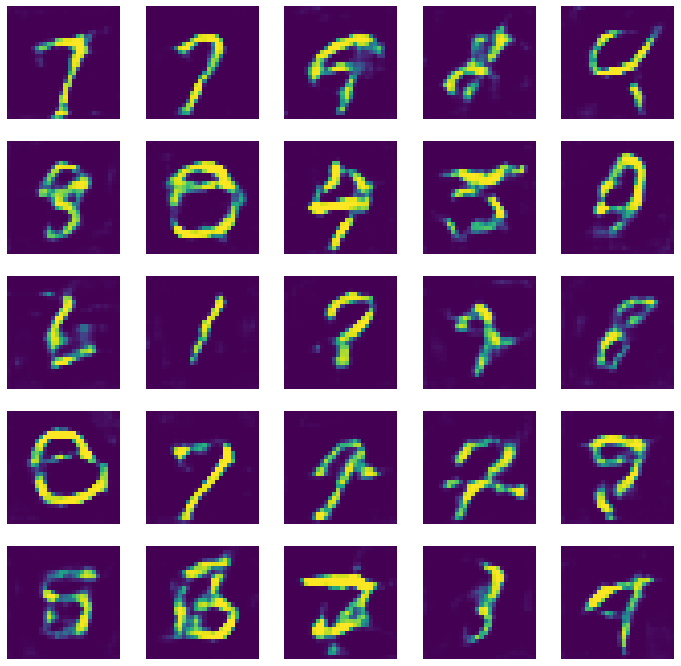

Epoch: 2


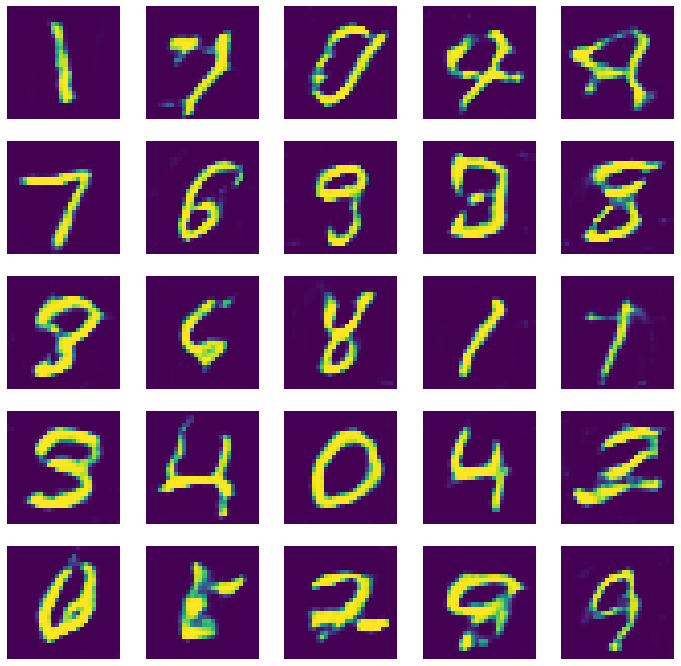

Epoch: 3


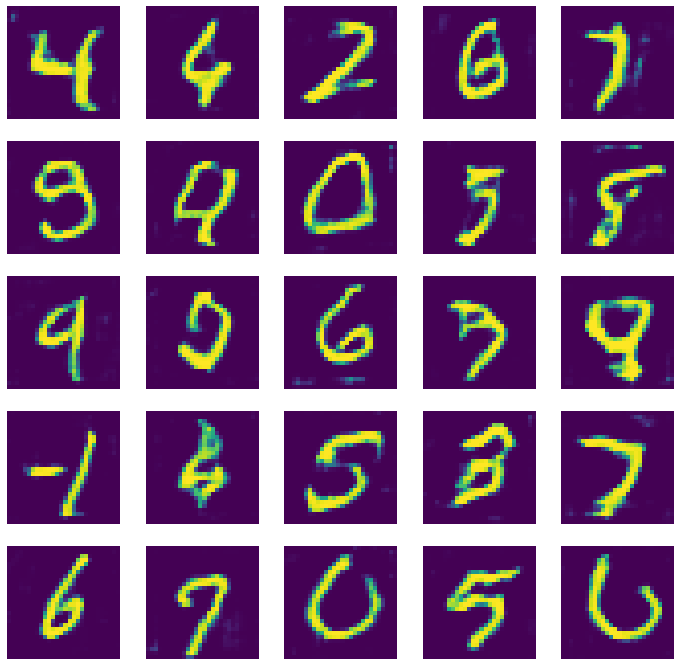

Epoch: 4


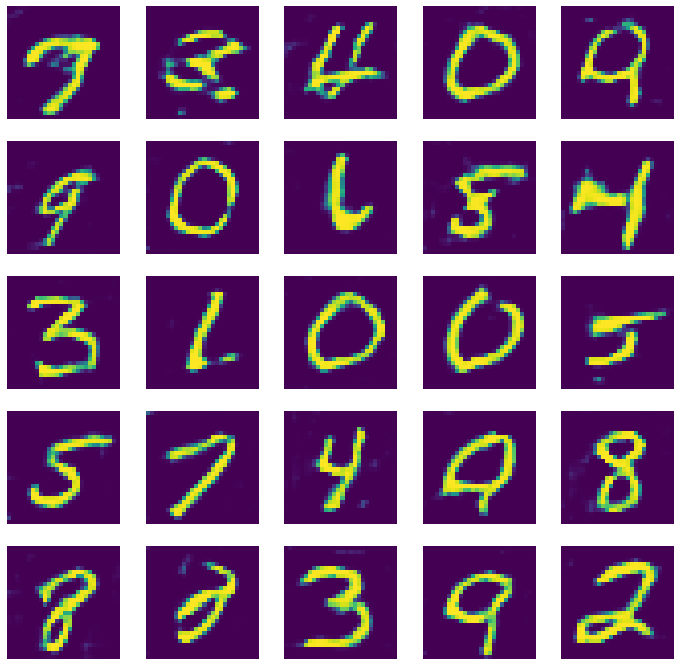

Epoch: 5


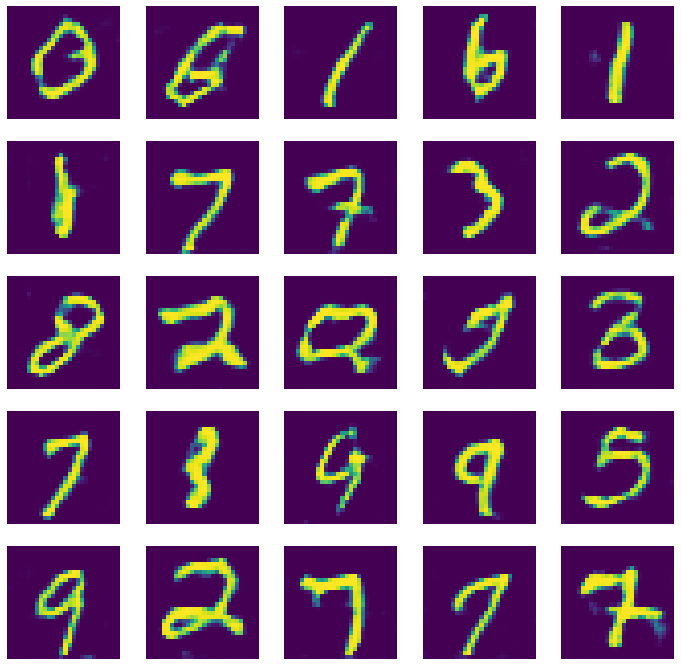

Epoch: 6


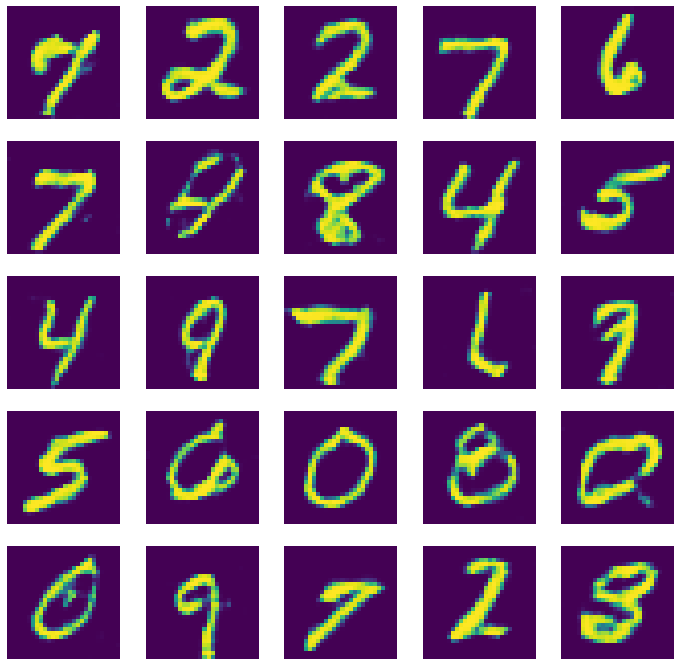

Epoch: 7


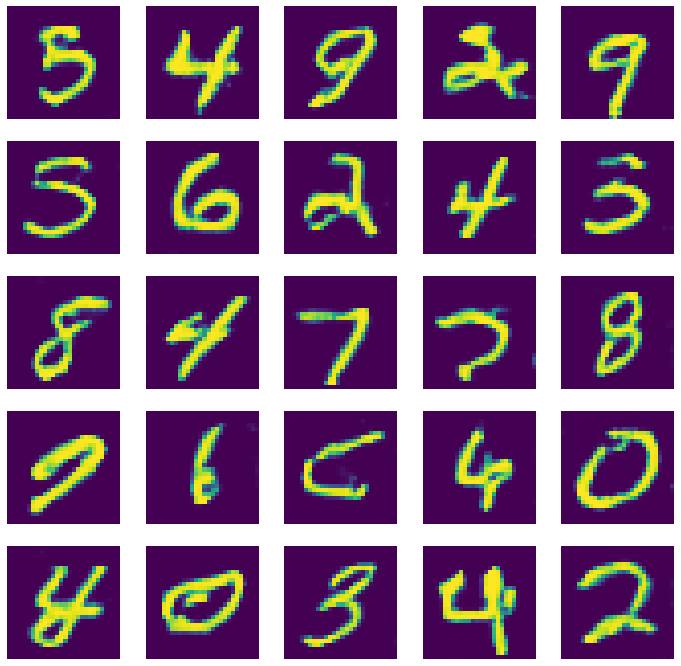

Epoch: 8


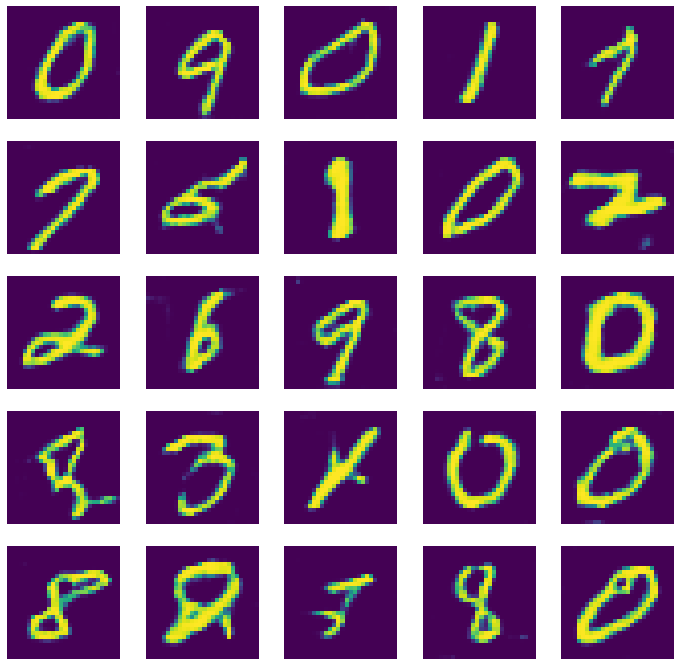

Epoch: 9


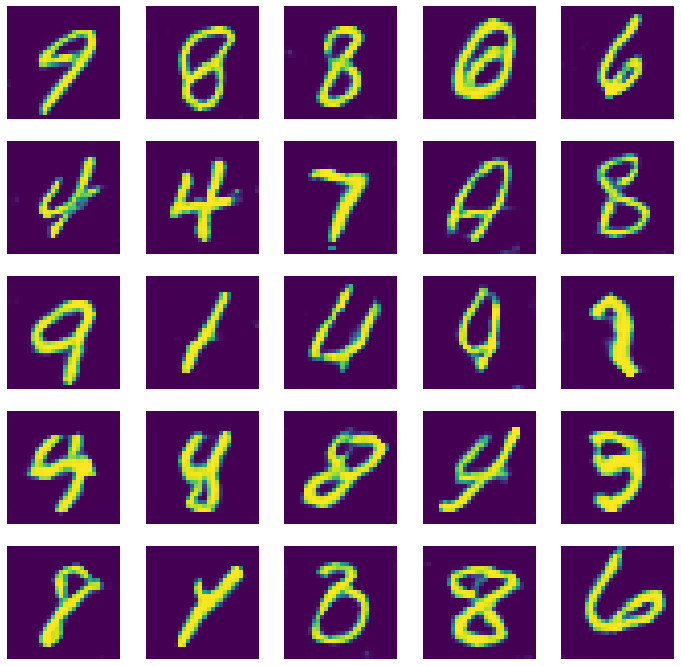

Epoch: 10


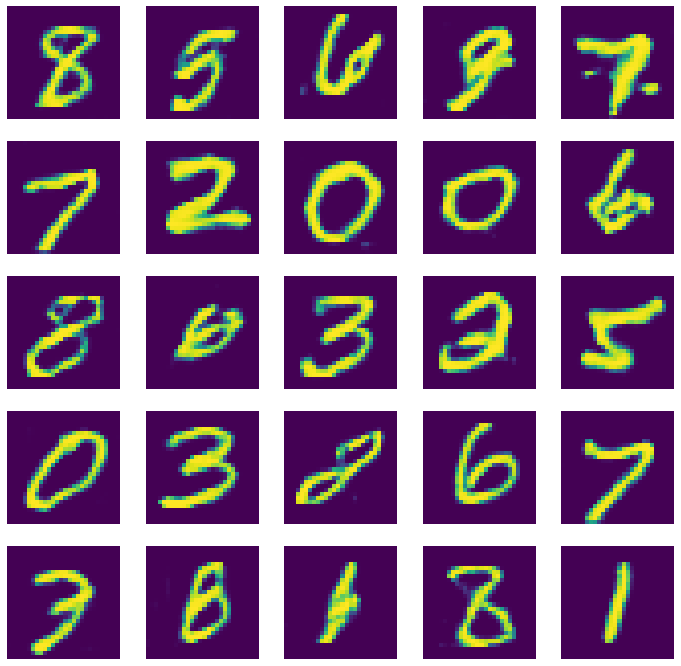

Epoch: 11


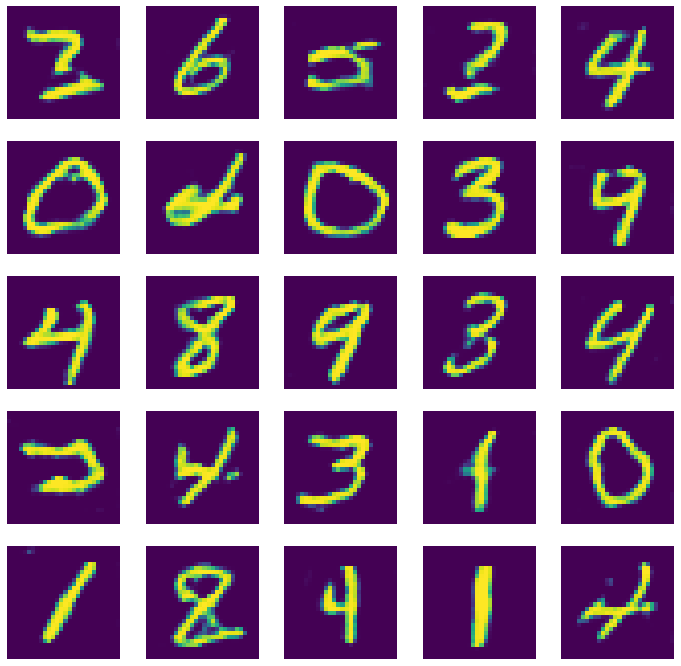

Epoch: 12


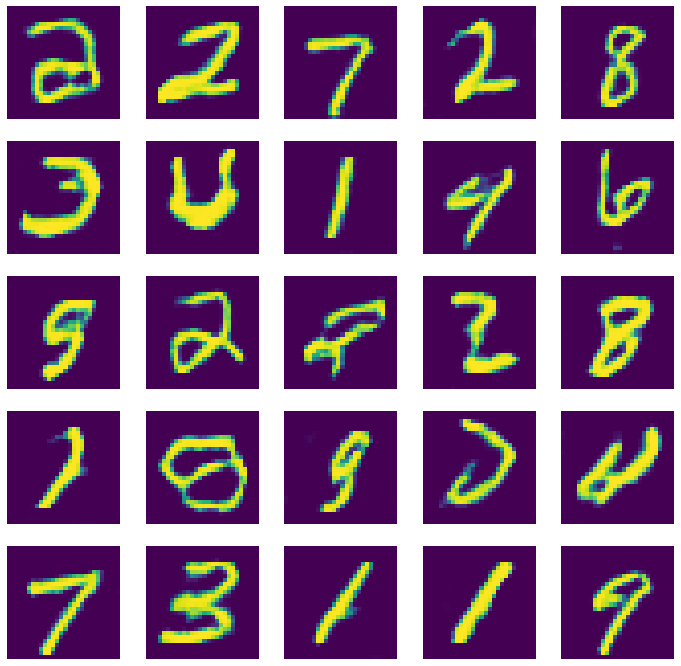

Epoch: 13


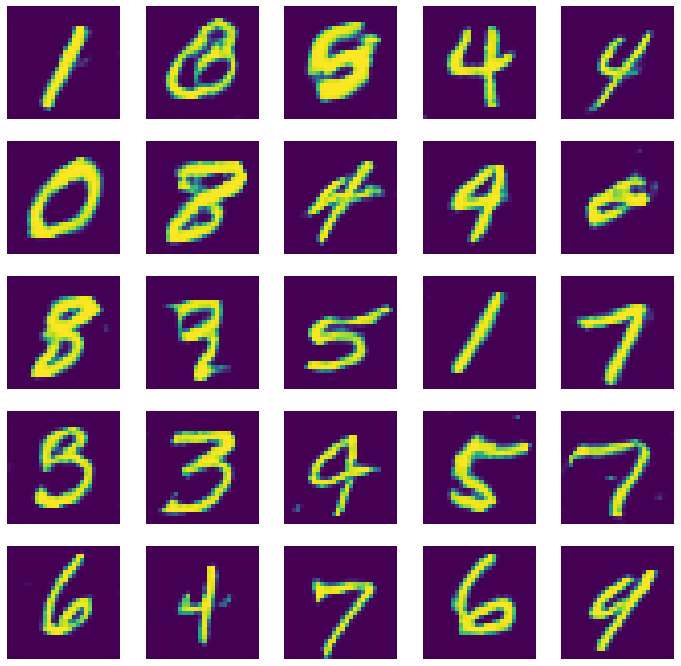

Epoch: 14


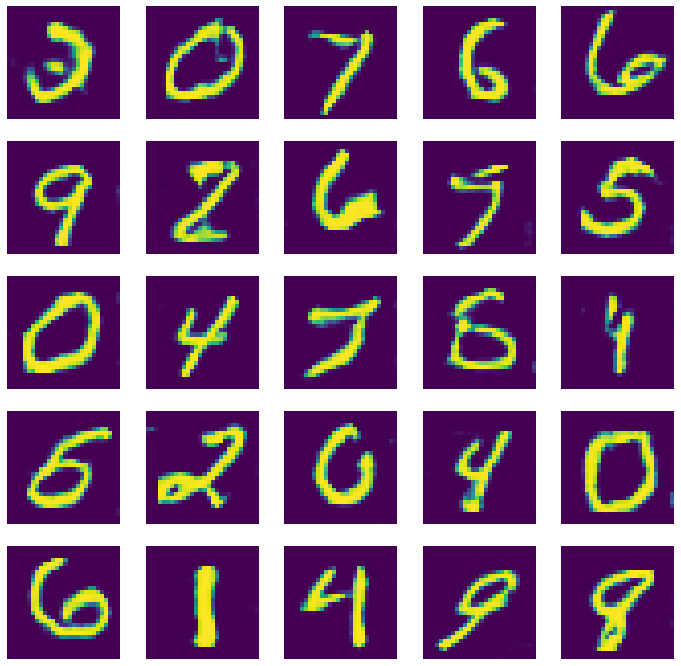

Epoch: 15


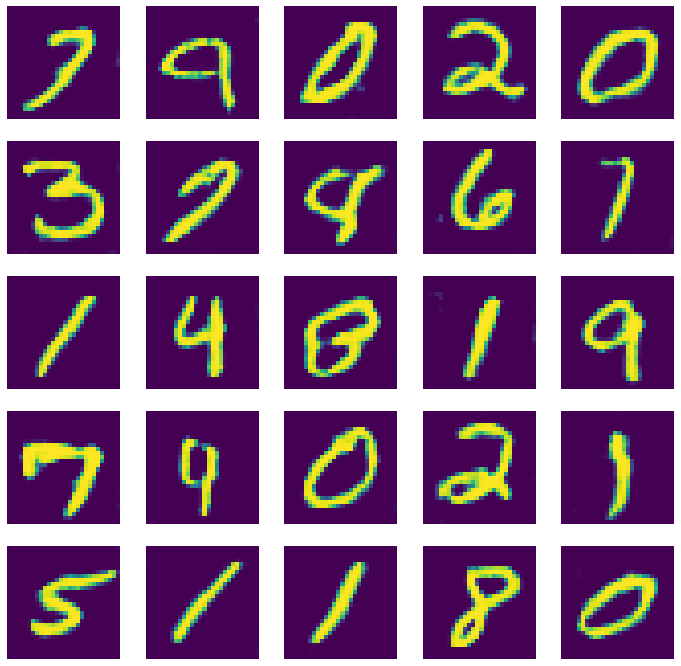

In [15]:
for epoch in range(num_epochs):
    for images in batched_data:
        # Sampling noise and generating a batch of new images
        noise = np.random.normal(0, 1, (batch_size, latent_dimensions))
        generated_images = generator.predict(noise)

        # Training the discriminator
        discriminator.train_on_batch(images, real)
        discriminator.train_on_batch(generated_images, fake)

        # Training the generator
        combined_network.train_on_batch(noise, real)

    if (epoch + 1) % display_interval == 0:
        print(f'Epoch: {epoch + 1}')
        display_images()